In [1]:
# load in melanoma/lung, map cancer stage to ordinal scale, identify correlating RNA expressions

# MIC, Pearson, Spearman, Distance correlation, monotonic_alignment, pca/fa

import omic_helpers
import numpy as np
import scipy as sc
import pandas as pd
import vaex as vx
import seaborn as sn

import ipyvolume as ipv
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
cm = sn.light_palette("green", as_cmap=True)

import sys, os, gc
from collections import defaultdict

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
def plot3d(xlist, title="", names=[]):
    fig = go.Figure(layout={'title': title})
    for idx, x in enumerate(xlist):
        name = names[idx]
        fig.add_trace(go.Scatter3d(
            x=x[:,0],
            y=x[:,1],
            z=x[:,2],
            mode='markers',
            marker={
                'size': 9,
                'opacity': 0.25,
            },
            name=name
        )
        )
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
    )
    plotly.offline.iplot(fig)

In [4]:
os.chdir('/media/bramiozo/DATA-FAST/genetic_expression/hackathon_2')

In [5]:
ctype='Lung'
include_alt_corrs = False

In [6]:
ds = {}
ds['RNAex'] = pd.read_csv(ctype+'/'+ctype+'_GeneExpression.txt', sep='\t')
ds['mutation'] = pd.read_csv(ctype+'/'+ctype+'_Mutation.txt', sep='\t')
#ds['methylation'] = vx.open(ctype+'Lung_Methylation.hdf5')
#ds['methylation_meta'] = vx.open(ctype+'HumanMethylation450_meta.hdf5')
#ds['CNV'] = vx.open(ctype+'Lung_CNV.hdf5')

In [7]:
miRNA = pd.read_csv(ctype+'/'+ctype+'_miRNA.txt', sep="\t")
mimamap = miRNA[['MIMATID', 'Name', 'Chr', 'Start', 'Stop', 'Strand']]
miRNA.drop(['Name', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
miRNA = miRNA.set_index('MIMATID').transpose()

proteome = pd.read_csv(ctype+'/'+ctype+"_Proteome.txt", sep="\t")
#proteome = proteome.set_index('sample').transpose()

meta = pd.read_csv(ctype+'/'+ctype+'_Phenotype_Metadata.txt', sep='\t')
meta = meta[~meta.SampleID.duplicated(keep='last')]
meta['SampleID']  = meta.SampleID.str.replace("\-", "_")
meta.set_index('SampleID', inplace=True)

In [8]:
meta_cols = ['Gender', 'Diagnosis', 'Age At Diagnosis (Years)', 
             'Overall Survival Status', 'Pack Years', 'Smoking Status',
             'Time To Overall Survival (Days)']
meta_cols = meta_cols + ['New Tumor Event', 'Radiation Therapy', 'Reponse To Therapy', 'Drug Therapy Type']

stage_map = {'stage i': 1, 'stage ia': 1.5, 'stage ib': 1.75,
             'stage ii': 2, 'stage iia': 2.5, 'stage iib': 2.75,
             'stage iii': 3,'stage iiia': 3.5, 'stage iiib': 3.75,
             'stage iv' : 4}
meta['Stage'] = meta['Tumor Stage'].map(stage_map)
########
if ctype=='Lung':
    smoke_map = {'Current Reformed Smoker < or = 15 yrs': 'reformed', 
                 'Current Reformed Smoker for > 15 yrs': 'reformed',
                 'Current Reformed Smoker, Duration Not Specified': 'reformed',
                 'Current Smoker': 'current',
                 'Lifelong Non-Smoker': 'non-smoker'}
    meta['Smoking'] = meta['Smoking Status'].map(smoke_map)
########
response_map = {'Progressive Disease': 0,
                'Complete Remission/Response': 1,
                'Stable Disease': 0,
                'Partial Remission/Response': 1}
meta['Response'] = meta['Response To Therapy'].map(response_map)

meta.dropna(subset=['Overall Survival Status'], inplace=True)
meta['Overall Survival Status'] =  meta['Overall Survival Status'].astype(int)

gender_map = {'male': 0, 'female': 1}
meta['Gender'] = meta['Gender'].map(gender_map)

meta_cols = list(set(meta_cols + ['Stage', 'Smoking', 'Response', 'Sample Type']))
meta.reset_index(inplace=True)
meta['SampleID'] = meta.SampleID.apply(lambda x: x.replace("_", "-"))
meta.set_index('SampleID', inplace=True)

In [9]:
meta = meta[meta['Sample Type']=='Primary Tumor']

In [10]:
ds['RNAex'].Gene = ds['RNAex'].Gene.str.upper()
ds['RNAex'].sort_values(by='Gene', inplace=True)
ds['RNAex'].Start = ds['RNAex'].Start.astype(str)
ds['RNAex'].Stop = ds['RNAex'].Stop.astype(str)
ds['RNAex'].Strand = ds['RNAex'].Strand.astype(str)
ds['RNAex']['rnaID'] = ds['RNAex'][['Gene', 'Chr', 'Start', 'Stop', 'Strand']].apply(lambda x:
                                                                                     "_".join(x), axis=1)
rnamap = ds['RNAex'][['rnaID', 'Gene', 'Chr', 'Start', 'Stop', 'Strand']]
rnamap['rnaID'].reset_index(drop=True, inplace=True)
rnamap.drop_duplicates(subset=['Gene', 'Chr', 'Start', 'Stop', 'Strand'])
ds['RNAex'].drop(['Gene', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
ds['RNAex'] = ds['RNAex'].set_index('rnaID').transpose()
gc.collect()
rnamap.set_index('rnaID', inplace=True)

## RNA expression diff analysis for continuous Targets

In [ ]:
# Stage, time_to_death, time_to_survival, time_to_relapse

In [32]:
meta['time_to_death'] = np.nan
meta.loc[meta['Overall Survival Status']==1, 'time_to_death'] = meta['Time To Overall Survival (Days)']

meta['time_to_relapse'] = np.nan
meta.loc[meta['Relapse Status']==1, 'time_to_relapse'] = meta['Time To Relapse From Diagnosis (Days)']

meta['time_to_survival'] = np.nan
meta.loc[meta['Overall Survival Status']==0, 'time_to_survival'] = meta['Time To Overall Survival (Days)']

In [55]:
target = 'Stage'
X = ds['RNAex'].join(meta[[target]], how='inner')

In [56]:
X.dropna(subset=[target], inplace=True)
Y = X[[target]]
X.drop([target], axis=1, inplace=True)

In [57]:
lincorr_dict = dict()
print("Spearman correlations")
lincorr_dict['spearman']= omic_helpers.spearman_scores(X,Y[target], return_df=True, correction='bonferroni')
print("Pearson correlations")
lincorr_dict['pearson']= omic_helpers.pearson_scores(X,Y[target], return_df=True, correction='bonferroni')
if include_alt_corrs:
    print("Monotonic aligned")
    lincorr_dict['monotonic_aligned'] = omic_helpers.monotonic_alignment(X,Y[[target]], return_df=True)
    print("Distance correlation")
    lincorr_dict['distance_correlation'] = omic_helpers.distcorr(X, Y[[target]], per_column=True,
                                                             return_df=True, columns=['distance_correlation'])
#lincorr_dict['mine'] = omic_helpers.mic_scores(X, Y[target], return_df=True)
lincorr = pd.concat(list(lincorr_dict.values()), axis=1)
lincorr.sort_values(by='spearman_pval', ascending=False, inplace=True)

Spearman correlations


/home/bramiozo/VIRTUALENVS/multi_omics/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning:

invalid value encountered in true_divide

/home/bramiozo/VIRTUALENVS/multi_omics/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning:

invalid value encountered in true_divide

/home/bramiozo/VIRTUALENVS/multi_omics/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/home/bramiozo/VIRTUALENVS/multi_omics/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/home/bramiozo/VIRTUALENVS/multi_omics/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



Pearson correlations


/home/bramiozo/VIRTUALENVS/multi_omics/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.



In [58]:
lincorr.dropna(inplace=True)
scores = lincorr.join(rnamap, how='inner')

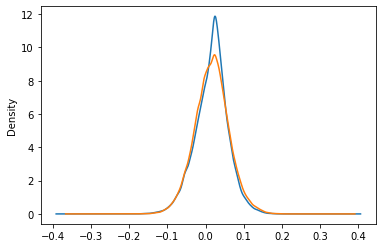

In [59]:
#scores.distance_correlation.plot.kde()
scores.pearson_score.plot.kde()
scores.spearman_score.plot.kde()

In [62]:
scores[(scores.spearman_pval<0.05) & (scores.spearman_score>0)].sort_values(by='spearman_pval', ascending=True)

,spearman_score,spearman_pval,pearson_score,pearson_pval,Gene,Chr,Start,Stop,Strand
HSPB1_chr7_76302544_76304295_+,0.201846,0.000909,0.204757,0.000557,HSPB1,chr7,76302544,76304295,+
TBC1D10A_chr22_30291990_30327046_-,0.201327,0.000991,0.206701,0.000400,TBC1D10A,chr22,30291990,30327046,-
FMO4_chr1_171314208_171342084_+,0.196710,0.002119,0.198081,0.001694,FMO4,chr1,171314208,171342084,+
SESN3_chr11_95165540_95232541_-,0.193611,0.003492,0.182197,0.020527,SESN3,chr11,95165540,95232541,-
TEF_chr22_41367333_41399326_+,0.192675,0.004055,0.192695,0.004042,TEF,chr22,41367333,41399326,+
NTRK2_chr9_84668551_85027070_+,0.190588,0.005642,0.154397,0.980227,NTRK2,chr9,84668551,85027070,+
TESK2_chr1_45343883_45491166_-,0.188893,0.007359,0.173315,0.075591,TESK2,chr1,45343883,45491166,-
PTPRQ_chr12_80402178_80680234_+,0.188623,0.007675,0.064188,4505.694219,PTPRQ,chr12,80402178,80680234,+
ASCC2_chr22_29788608_29838304_-,0.188488,0.007838,0.181880,0.021528,ASCC2,chr22,29788608,29838304,-
ATP13A5_chr3_193274790_193378843_-,0.188191,0.008209,0.112070,109.142928,ATP13A5,chr3,193274790,193378843,-


In [64]:
scores[(scores.pearson_pval<0.05) & (scores.spearman_score<0)].sort_values(by='spearman_pval', ascending=True)

,spearman_score,spearman_pval,pearson_score,pearson_pval,Gene,Chr,Start,Stop,Strand
KRT18_chr12_52948871_52952901_+,-0.177230,0.042890,-0.188217,0.008175,KRT18,chr12,52948871,52952901,+
KRT18P28_chr1_182959074_182960405_-,-0.170402,0.114290,-0.177067,0.043930,KRT18P28,chr1,182959074,182960405,-
OPN3_chr1_241590102_241677376_-,-0.147530,2.314909,-0.192096,0.004446,OPN3,chr1,241590102,241677376,-
CIDEC_chr3_9866711_9880254_-,-0.125822,27.461842,-0.182404,0.019898,CIDEC,chr3,9866711,9880254,-


## Differential analysis for discrete Targets

In [ ]:
# single feature logistic regressor?, 5-fold CV accuracy as score?
# add to omics_helpers?

# Response
